## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib widget


## Loading in dataframe

In [2]:
data_path = '../processed_data.csv'
data = pd.read_csv(data_path)
data['energy(kWh/hh)'] = data['energy(kWh/hh)'].astype(float) / data['houses']
data.info()
data.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40405 entries, 0 to 40404
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           40405 non-null  int64  
 1   timestamp       40405 non-null  object 
 2   year            40405 non-null  int64  
 3   month           40405 non-null  int64  
 4   day             40405 non-null  int64  
 5   hour            40405 non-null  int64  
 6   minute          40405 non-null  int64  
 7   day_of_week     40405 non-null  int64  
 8   weekend         40405 non-null  int64  
 9   holiday         40405 non-null  int64  
 10  energy(kWh/hh)  40405 non-null  float64
 11  houses          40405 non-null  int64  
 12  visibility      39727 non-null  float64
 13  temperature     39727 non-null  float64
 14  dewPoint        39727 non-null  float64
 15  pressure        39727 non-null  float64
 16  windSpeed       39727 non-null  float64
 17  precipType      39727 non-null 

,index,timestamp,year,month,day,hour,minute,day_of_week,weekend,holiday,energy(kWh/hh),houses,visibility,temperature,dewPoint,pressure,windSpeed,precipType,humidity
0,0,2011-11-23 09:00:00+00:00,2011,11,23,9,0,2,0,0,0.284500,2,4.390000,4.840000,4.680000,1027.290000,1.780000,0.0,0.990000
1,1,2011-11-23 09:30:00+00:00,2011,11,23,9,30,2,0,0,0.280500,2,5.068612,5.190130,5.095420,1027.507662,1.824055,0.0,0.992222
2,2,2011-11-23 10:00:00+00:00,2011,11,23,10,0,2,0,0,0.153333,6,6.240000,5.740000,5.460000,1027.670000,1.990000,0.0,0.980000
3,3,2011-11-23 10:30:00+00:00,2011,11,23,10,30,2,0,0,0.098000,6,8.261031,6.686929,5.598355,1027.672961,2.336091,0.0,0.931400
4,4,2011-11-23 11:00:00+00:00,2011,11,23,11,0,2,0,0,0.110286,7,10.200000,7.670000,5.740000,1027.560000,2.660000,0.0,0.880000


['month', 'day', 'hour', 'minute', 'day_of_week', 'weekend', 'holiday', 'visibility', 'temperature', 'windSpeed', 'precipType', 'humidity', 'energy(kWh/hh)', 'energy(kWh/hh)_prev_half', 'energy(kWh/hh)_prev_hour', 'energy(kWh/hh)_next_half', 'energy(kWh/hh)_next_hour']


,month,day,hour,minute,day_of_week,weekend,holiday,visibility,temperature,windSpeed,precipType,humidity,energy(kWh/hh),energy(kWh/hh)_prev_half,energy(kWh/hh)_prev_hour,energy(kWh/hh)_next_half,energy(kWh/hh)_next_hour
0,11,23,9,0,2,0,0,4.390000,4.840000,1.780000,0.0,0.990000,0.284500,NaN,NaN,0.280500,0.153333
1,11,23,9,30,2,0,0,5.068612,5.190130,1.824055,0.0,0.992222,0.280500,0.284500,NaN,0.153333,0.098000
2,11,23,10,0,2,0,0,6.240000,5.740000,1.990000,0.0,0.980000,0.153333,0.280500,0.284500,0.098000,0.110286
3,11,23,10,30,2,0,0,8.261031,6.686929,2.336091,0.0,0.931400,0.098000,0.153333,0.280500,0.110286,0.193000
4,11,23,11,0,2,0,0,10.200000,7.670000,2.660000,0.0,0.880000,0.110286,0.098000,0.153333,0.193000,0.394222


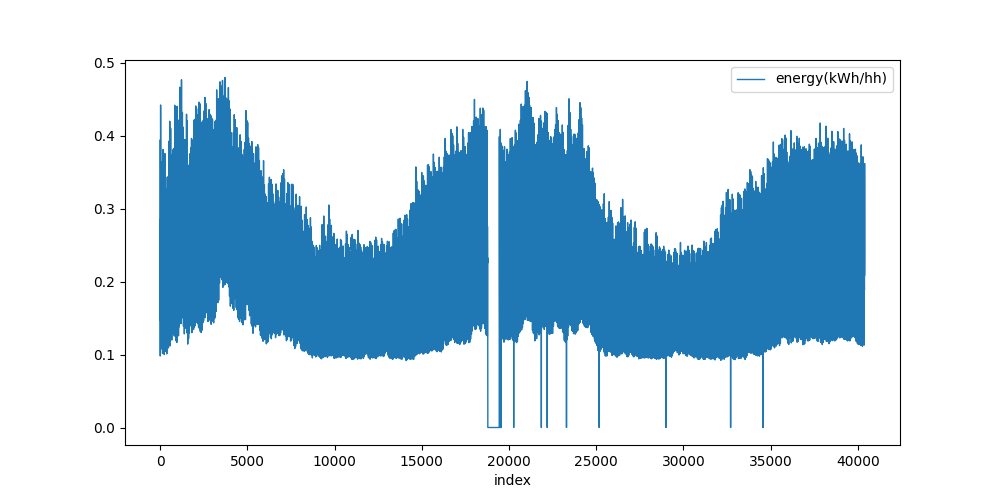

In [15]:

data.plot(x='index', y='energy(kWh/hh)', figsize=(10,5), linewidth=1, fontsize=10)
data_mod = data.drop(['index','timestamp', 'year', 'houses', 'pressure', 'dewPoint'], axis=1)
data_mod.head()

data_mod['energy(kWh/hh)_prev_half'] = data_mod['energy(kWh/hh)'].shift(1)
data_mod['energy(kWh/hh)_prev_hour'] = data_mod['energy(kWh/hh)'].shift(2)
data_mod['energy(kWh/hh)_next_half'] = data_mod['energy(kWh/hh)'].shift(-1)
data_mod['energy(kWh/hh)_next_hour'] = data_mod['energy(kWh/hh)'].shift(-2)

columns = data_mod.columns.to_list()
columns.remove('energy(kWh/hh)')
columns.insert(12, 'energy(kWh/hh)')
print(columns)

data_mod = data_mod[columns]

data_mod.head()

## Removing Datapoints without previous or next info

,month,day,hour,minute,day_of_week,weekend,holiday,visibility,temperature,windSpeed,precipType,humidity,energy(kWh/hh),energy(kWh/hh)_prev_half,energy(kWh/hh)_prev_hour,energy(kWh/hh)_next_half,energy(kWh/hh)_next_hour
0,11,23,10,0,2,0,0,6.240000,5.740000,1.990000,0.0,0.980000,0.153333,0.280500,0.284500,0.098000,0.110286
1,11,23,10,30,2,0,0,8.261031,6.686929,2.336091,0.0,0.931400,0.098000,0.153333,0.280500,0.110286,0.193000
2,11,23,11,0,2,0,0,10.200000,7.670000,2.660000,0.0,0.880000,0.110286,0.098000,0.153333,0.193000,0.394222
3,11,23,11,30,2,0,0,11.125204,8.328295,2.759402,0.0,0.859381,0.193000,0.110286,0.098000,0.394222,0.304100
4,11,23,12,0,2,0,0,11.620000,8.840000,2.800000,0.0,0.850000,0.394222,0.193000,0.110286,0.304100,0.258333


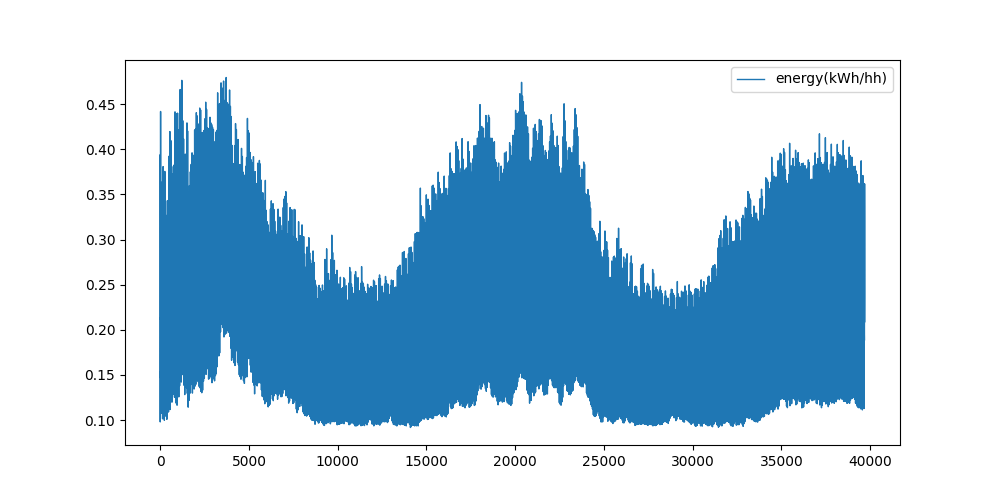

In [19]:
# Removing NaN value rows
data_mod_clean = data_mod[data_mod['energy(kWh/hh)_prev_hour'].notna()]

# Removing rows with energy consumption of 0
data_mod_clean = data_mod_clean.reset_index(drop=True)
data_mod_clean = data_mod_clean.drop(np.where(data_mod_clean['energy(kWh/hh)'] <= 0.0)[0])

# Removing rows with previous energy consumption of 0 (Catches prev_half and prev_hour)
data_mod_clean = data_mod_clean.reset_index(drop=True)
data_mod_clean = data_mod_clean.drop(np.where(data_mod_clean['energy(kWh/hh)_prev_hour'] <= 0.0)[0])

# Removing rows with next energy consumption of 0 (Catches next_half and next_hour)
data_mod_clean = data_mod_clean.reset_index(drop=True)
data_mod_clean = data_mod_clean.drop(np.where(data_mod_clean['energy(kWh/hh)_next_half'] <= 0.0)[0])

data_mod_clean = data_mod_clean.reset_index(drop=True)

data_mod_clean.plot(y='energy(kWh/hh)', figsize=(10,5), linewidth=1, fontsize=10)

data_mod_clean.head()